## Cook County Housing Project

<b>Motivation</b>: According to an [article](www.propertytaxproject.uchicago.edu) from the University of Chicago, "70% of the lowest value homes are overassessed and 29% of the highest value homes are overassessed" (Berry 2022). This over valuation of homes also means that people with cheaper homes are more likely to pay more than they are required in property taxes. 

<b>Solution:</b> In this project, I will create a linear regression model that will more accurately predict the value of Cook County properties in order to remedy the County's regressive tax structure.

In [666]:
#imports
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [667]:
#extracting data 
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [668]:
#loading in data
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [669]:
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Month of Year,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size
0,17294100610000,203,50,2500.0,76,0.0,2.0,1.0,1.0,3.0,...,9,2,1.0,13.2,0,0.0,50,7650,"This property, sold on 09/14/2015, is a one-st...",2500.0
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,5,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,2,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,7,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0


In [670]:
# 204792 observations and 62 features in training data
training_data.shape

(204792, 62)

In [671]:
training_data.columns

Index(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material', 'Basement',
       'Basement Finish', 'Central Heating', 'Other Heating', 'Central Air',
       'Fireplaces', 'Attic Type', 'Attic Finish', 'Design Plan',
       'Cathedral Ceiling', 'Construction Quality', 'Site Desirability',
       'Garage 1 Size', 'Garage 1 Material', 'Garage 1 Attachment',
       'Garage 1 Area', 'Garage 2 Size', 'Garage 2 Material',
       'Garage 2 Attachment', 'Garage 2 Area', 'Porch', 'Other Improvements',
       'Building Square Feet', 'Repair Condition', 'Multi Code',
       'Number of Commercial Units', 'Estimate (Land)', 'Estimate (Building)',
       'Deed No.', 'Sale Price', 'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       'O'Hare Noise', 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year',
     

In [672]:
training_data['Site Desirability'].value_counts()

2.0    203605
1.0       896
3.0       291
Name: Site Desirability, dtype: int64

In [673]:
#example description
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

### Data Context

In this dataset, each row represents a different property in Cook County, Illinois. This data was collected by the Cook County Assessor's Office to determine property taxes for properties in Cook County.

### Looking at "Sale Price"

In [674]:
# function to look at distribution of data
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].artists[0].set_facecolor('white')

In [675]:
#Creating Log Sale Price feature to better see Sale Price Data 

training_data = training_data[training_data["Sale Price"] >= 500]
training_data["Log Sale Price"] = np.log(training_data["Sale Price"])

In [676]:
training_data["Sale Price"].describe()

count    1.689310e+05
mean     2.972082e+05
std      3.796823e+05
min      5.000000e+02
25%      1.210000e+05
50%      2.150000e+05
75%      3.500000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

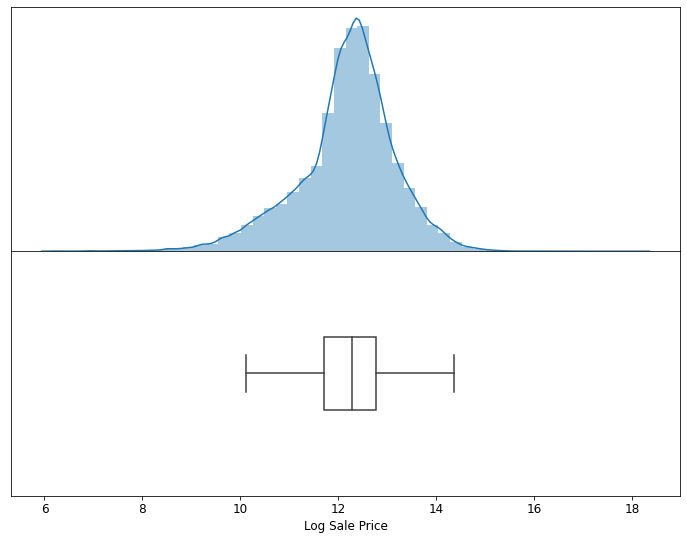

In [677]:
# looking a distribution of Log Sale Price
plot_distribution(training_data, label='Log Sale Price');

In [678]:
# Log transforming Building Square Feet
training_data["Log Building Square Feet"] = np.log(training_data["Building Square Feet"])

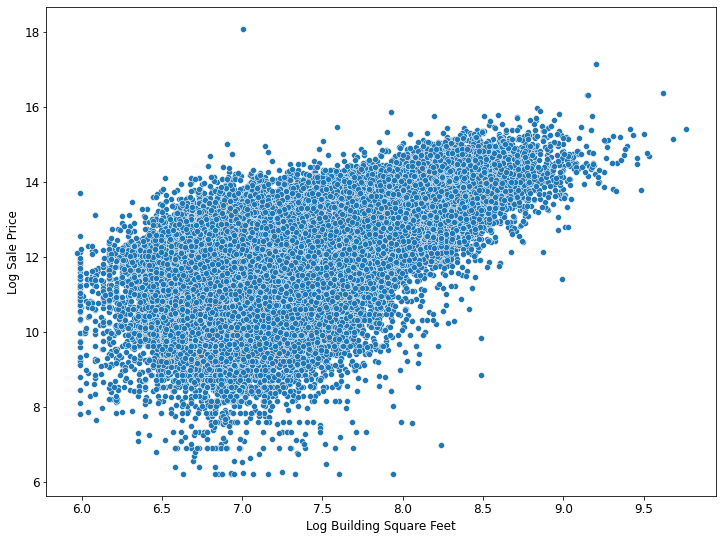

In [679]:
sns.scatterplot(data = training_data, x = "Log Building Square Feet", y ='Log Sale Price');

As shown by this scatter plot, there appears to be a positive correlation between Log Building Square Feet and Log Sale Price in the scatterplot. For this reason, "Log Building Square Feet" could definitely be used as a feature for the model to estimate property value.

In [680]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
    """  
    data = data[data[variable] >= lower]
    data = data[data[variable] <= upper]
    return data

In [681]:
training_data['Description'][1]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

One feature that might be useful but is not available in the dataset is the number of rooms in the property. We can, however, find this data in the 'Description' column of the dataset. In the next cell, I will create a function to extract this data.

In [682]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    
    with_rooms["Bedrooms"] = data["Description"].str.extract("(\d+) of which are bedroom").astype(int)
    with_rooms["Bedrooms"] = with_rooms["Bedrooms"].fillna(0)
    return with_rooms

training_data = add_total_bedrooms(training_data)

In [683]:
training_data["Bedrooms"].value_counts()

3     83264
4     44404
2     30618
5      7936
6      1910
1       467
7       223
8        80
9        22
10        6
14        1
Name: Bedrooms, dtype: int64

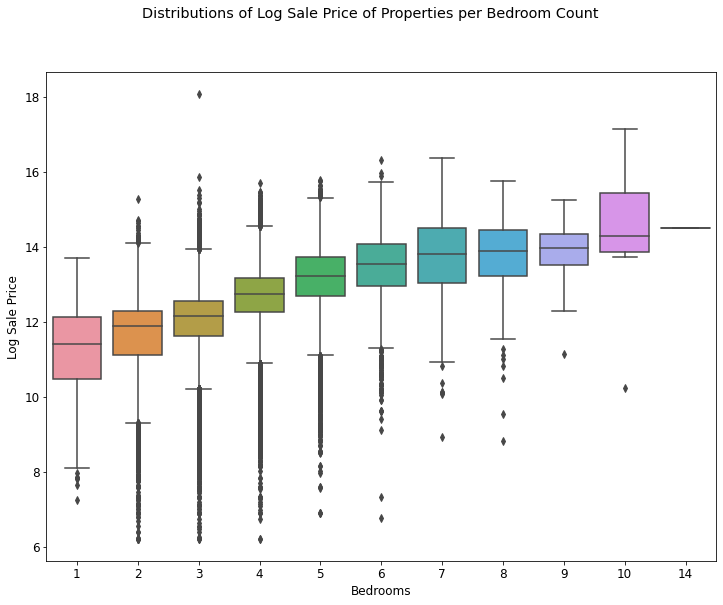

In [684]:
sns.boxplot(data = training_data, x = "Bedrooms", y = "Log Sale Price")
plt.suptitle("Distributions of Log Sale Price of Properties per Bedroom Count");

From this visual, we can see that Log Sale Price increases with additional bedrooms on the property.

In [685]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    
    with_rooms["Bathrooms"] = np.log(training_data["Description"].str.extract("and (\d+.\d+) of which are bathrooms").astype(float))
    with_rooms["Bathrooms"] = with_rooms["Bathrooms"].fillna(0)
    return with_rooms

training_data = add_total_bathrooms(training_data)

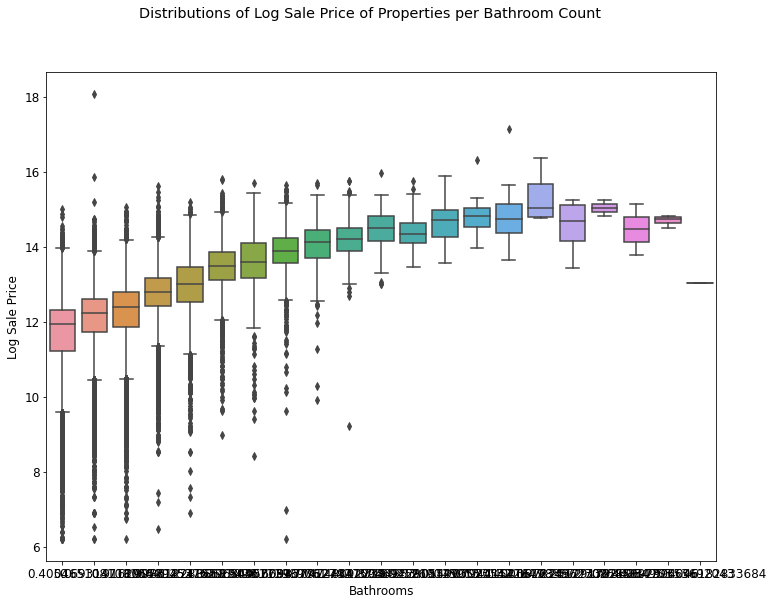

In [686]:
sns.boxplot(data = training_data, x = "Bathrooms", y = "Log Sale Price")
plt.suptitle("Distributions of Log Sale Price of Properties per Bathroom Count");

In [687]:
# function to visualize distribution of Log Sale Prices of homes from different neighborhoods
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [688]:
#creating table with data from 20 neighborhoods
first_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(training_data["Neighborhood Code"].value_counts().index[0:20])]

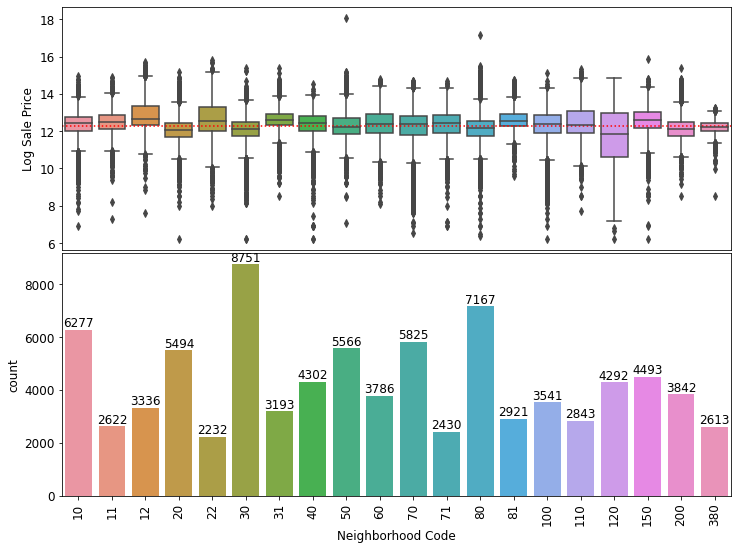

In [689]:
plot_categorical(neighborhoods= first_20_neighborhoods)

For most neighborhoods, the majority of homes are similar in price. However, the spread of homes in each neighborhhod are pretty large, with many outliers for each distribution. The relationship between the houses' Log Sale Price and their neighborhood is not very strong as the median of all of the distributions are relatively close to each other on the graph.

However, we can add a feature to help us identify if a neighborhood is more expensive or cheaper than others overall.

In [690]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data[["Neighborhood Code", "Log Sale Price"]].groupby("Neighborhood Code").agg(metric).sort_values("Log Sale Price", ascending = False).index[0:n]
    
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [691]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data["Neighborhood Code"].isin(neighborhoods).astype(int)
    return data

#adding expensive neighborhood feature to dataframe
expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [692]:
def find_cheap_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n lowest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data[["Neighborhood Code", "Log Sale Price"]].groupby("Neighborhood Code").agg(metric).sort_values("Log Sale Price", ascending = True).index[0:n]
    
    return [int(code) for code in neighborhoods]

cheap_neighborhoods = find_cheap_neighborhoods(training_data, 3, np.median)
cheap_neighborhoods

[330, 121, 251]

In [693]:
def add_in_cheap_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_cheap_neighborhood column
    """
    data['in_cheap_neighborhood'] = data["Neighborhood Code"].isin(neighborhoods).astype(int)
    return data

#adding expensive neighborhood feature to dataframe
cheap_neighborhoods = find_cheap_neighborhoods(training_data, 3, np.median)
training_data = add_in_cheap_neighborhood(training_data, cheap_neighborhoods)

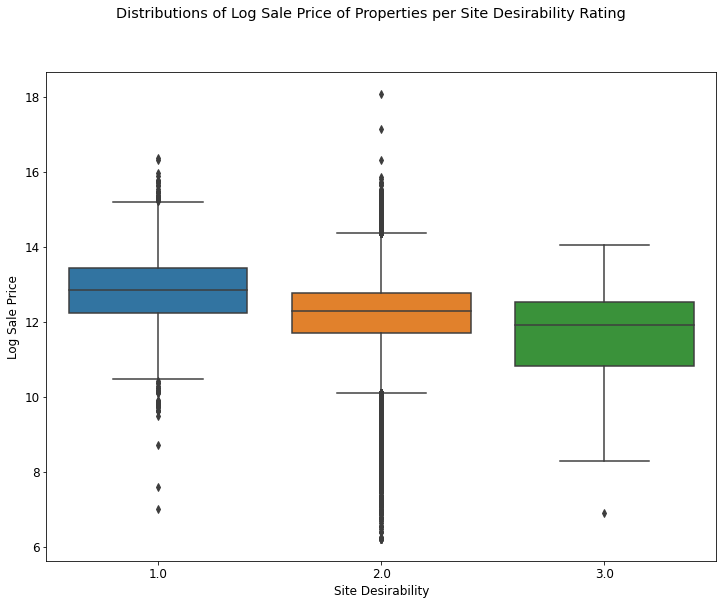

In [694]:
sns.boxplot(data = training_data, x = "Site Desirability", y = "Log Sale Price")
plt.suptitle("Distributions of Log Sale Price of Properties per Site Desirability Rating");

In [695]:
def add_undesirable(data):
    """
    Input:
      data (data frame): a data frame containing a 'Site Desirability' column with values
        found in the codebook
    Output:
      data frame identical to the input with the addition of a binary
      undesirable column
    """
    data["Undesirable"] = [1 if item == 3 else 0 for item in data["Site Desirability"]]
    return data

training_data = add_undesirable(training_data)

In [696]:
def add_desirable(data):
    """
    Input:
      data (data frame): a data frame containing a 'Site Desirability' column with values
        found in the codebook
    Output:
      data frame identical to the input with the addition of a binary
      desirable column
    """
    data["Desirable"] = [1 if item == 1 else 0 for item in data["Site Desirability"]]
    return data

training_data = add_desirable(training_data)

### Roof and Wall Material Features

In [697]:
training_data["Roof Material"].value_counts()

1.0    160760
2.0      3774
4.0      1620
5.0      1201
6.0       841
3.0       735
Name: Roof Material, dtype: int64

There are 6 different roof materials that have been encoded numerically into the dataset. Using the codebook, we can decode the materials.

In [698]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.replace(to_replace = {"Roof Material" : {1.0 : "Shingle/Asphalt", 2.0 : "Tar&Gravel", 3.0 : "Slate", 4.0 : "Shake", 5.0 : "Tile", 6.0: "Other"}}) 
    return data
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,Bathrooms,in_expensive_neighborhood,in_cheap_neighborhood,Undesirable,Desirable
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0.000000,0,0,0,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0.000000,0,0,0,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0.405465,0,0,0,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0.000000,0,0,0,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0.405465,0,0,0,0


Next, I will one hot encode the roof material data, creating 6 separate features so that we could potentially use them in a model.

In [699]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    new_df = data
   
    n = OneHotEncoder()
    n.fit(data[["Roof Material"]])
    
    new_df = pd.DataFrame(n.transform(data[["Roof Material"]]).todense(), 
                          columns = n.get_feature_names(), 
                          index = data.index)
    return data.join(new_df)

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


Repeating the same process for "Wall Material"

In [700]:
training_data["Wall Material"].value_counts() # 1=Wood, 2=Masonry, 3=Wood&Masonry, 4=Stucco

2.0    70303
1.0    59125
3.0    35717
4.0     3786
Name: Wall Material, dtype: int64

In [701]:
def substitute_wall_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Wall Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Wall Material' column
    """
    data = data.replace(to_replace = {"Wall Material" : {1.0 : "Wood", 2.0 : "Masonry", 3.0 : "Wood&Masonry", 4.0 : "Stucco"}}) 
    return data
    
training_data = substitute_wall_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,in_expensive_neighborhood,in_cheap_neighborhood,Undesirable,Desirable,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
1,13272240180000,202,120,3780.0,71,0.0,Masonry,Shingle/Asphalt,1.0,1.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,25221150230000,202,210,4375.0,70,0.0,Masonry,Shingle/Asphalt,2.0,3.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
3,10251130030000,203,220,4375.0,17,0.0,Wood&Masonry,Shingle/Asphalt,1.0,3.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4,31361040550000,202,120,8400.0,32,0.0,Wood&Masonry,Shingle/Asphalt,2.0,3.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
6,30314240080000,203,181,10890.0,37,0.0,Wood,Shingle/Asphalt,1.0,3.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0


In [702]:
#general one hot encoder
def ohe_(data, col):
    
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[col]])
    dummies = pd.DataFrame(oh_enc.transform(data[[col]]).todense(),
                           columns=oh_enc.get_feature_names(),
                           index = data.index)
    return data.join(dummies)

training_data = ohe_(training_data, 'Wall Material')
training_data.filter(regex='^x0').head(10)


,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile,x0_Masonry,x0_Stucco,x0_Wood,x0_Wood&Masonry
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Building the Model

In this next part of the project, I will focus on building a linear regression model to predict home values in Cook County.

In [703]:
#training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

In [705]:
#splitting data into train and test set
np.random.seed(1337)

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train = data.loc[shuffled_indices[0: int(data_len * 0.8)]]
    test = data.loc[shuffled_indices[int(data_len * 0.8): data_len]]
    return train, test
train, test = train_test_split(pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0'))

In [747]:
#helper functions

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

def log_transform_estimate(data, col):
    """Add the log transformation of a column to the data frame
    This function also accounts for when the data value is 0"""
    avg = np.mean(data[col])
    filled_col = [avg if np.log(item) == -np.inf else item for item in np.array(data[col])]
    data['Log ' + col] = np.log(filled_col)
    return data

def square_transform(data, col):
    """Add the squared transformation of a column to the data frame"""
    data[col + ' Squared'] = data[col] ** 2
    return data

def square_root_transform(data, col):
    """Add the squared transformation of a column to the data frame"""
    data[col + ' Square Root'] = data[col] ** (1/2)
    return data

def cube_transform(data, col):
    """Add the cube transformation of a column to the data frame"""
    data[col + ' Cubed'] = data[col] ** 3
    return data

In [707]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

## Two Simple Models

To start out, I will create two simple models that I can add onto later.

In [708]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]


X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')

In [709]:

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model

train_m2, test_m2 = train_test_split(full_data)
m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]
X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_test_m2, y_test_m2 = process_data_gm(test_m2, m2_pipelines, 'Log Sale Price')

In [710]:

from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [711]:

# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.fit(X_train_m1, y_train_m1).predict(X_train_m1)
y_predicted_m1 = linear_model_m1.fit(X_train_m1, y_train_m1).predict(X_test_m1)
    
# Fit the 2nd model
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.fit(X_train_m2, y_train_m2).predict(X_train_m2)
y_predicted_m2 = linear_model_m2.fit(X_train_m2, y_train_m2).predict(X_test_m2)

I will use root mean squared error as a performance metric for the models.

In [712]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [713]:

# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
test_error_m1 = rmse(y_predicted_m1, y_test_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.e ** y_fitted_m1, np.e ** y_train_m1)
test_error_m1_delog = rmse(np.e ** y_predicted_m1, np.e ** y_test_m1)


# Training and test errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
test_error_m2 = rmse(y_predicted_m2, y_test_m2)


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.e ** y_fitted_m2, np.e ** y_train_m2)
test_error_m2_delog = rmse(np.e ** y_predicted_m2, np.e ** y_test_m2)

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699076
Test RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149698616
Test RMSE: 310679.24866115686

2nd Model
Training RMSE: 0.8042009333446841
Test RMSE: 0.8113963052434994

2nd Model (no log transform)
Training RMSE: 325716.40819160343
Test RMSE: 254880.42228506115



In [714]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401040124
θ1: 0.49691974631413155
2nd Model
θ0: 1.9339633173823856
θ1: -0.030647249803552674
θ2: 1.4170991378689612


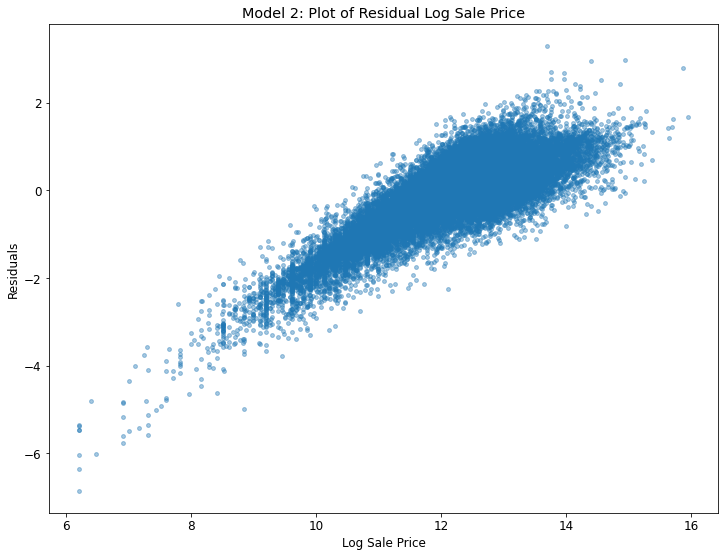

In [715]:
plt.scatter(y_test_m2, y_test_m2 - y_predicted_m2, s = 15, alpha = 0.4)
plt.xlabel("Log Sale Price")
plt.ylabel("Residuals")
plt.title("Model 2: Plot of Residual Log Sale Price");


Looking at this residual plot, we can see that our predictions overestimate for less expensive homes and underestimate for expensive homes. By adding more features and refining the model, I hope to eliminate this regressive pattern.

### Choosing Features

In order to build the best model, I will try to find features that have the highest correlation to Log Sale Price.

In [820]:
#looking at correlation between variables
training_data.corr().sort_values('Log Sale Price', ascending = False)[['Log Sale Price', 'Sale Price']].head(40)

,Log Sale Price,Sale Price
Log Sale Price,1.000000,0.658859
Sale Price,0.658859,1.000000
Estimate (Building),0.629079,0.718075
Log Building Square Feet,0.591699,0.537607
Building Square Feet,0.569264,0.595702
Latitude,0.540726,0.341657
Bathrooms,0.523721,0.486319
Estimate (Land),0.482124,0.605608
Fireplaces,0.457804,0.441372
Bedrooms,0.427943,0.401883


In [822]:
# looking at correlation between variables squared
training_data_squared = pd.DataFrame()
for col in training_data.columns:
    if type(training_data[col][1]) == np.float64 or type(training_data[col][1]) == np.int64:
        training_data_squared[col + " squared"] = training_data[col] ** 2

training_data_squared["Log Sale Price"] = training_data["Log Sale Price"]
training_data_squared.corr().sort_values('Log Sale Price', ascending = False)[['Log Sale Price']].head(40)

,Log Sale Price
Log Sale Price,1.000000
Log Sale Price squared,0.997364
Log Building Square Feet squared,0.592349
Latitude squared,0.540849
Bathrooms squared,0.527708
Building Square Feet squared,0.458291
Fireplaces squared,0.423757
Bedrooms squared,0.418431
Central Air squared,0.355114
Longitude squared,0.339203


In [746]:
# looking at correlation for variables cubed
training_data_cubed = pd.DataFrame()
for col in training_data.columns:
    if type(training_data[col][1]) == np.float64 or type(training_data[col][1]) == np.int64:
        training_data_cubed[col + " cubed"] = training_data[col] ** 2

training_data_cubed["Log Sale Price"] = training_data["Log Sale Price"]
training_data_cubed.corr().sort_values('Log Sale Price', ascending = False)[['Age cubed']].head(40)

,Age cubed
Log Sale Price,-0.175137
Log Sale Price cubed,-0.168526
Log Building Square Feet cubed,-0.254611
Latitude cubed,0.014637
Bathrooms cubed,-0.256278
Building Square Feet cubed,-0.192366
Fireplaces cubed,-0.195000
Bedrooms cubed,-0.104260
Central Air cubed,-0.386754
Longitude cubed,-0.315238


In [823]:
# looking at correlation for root variables
training_data_sqrt = pd.DataFrame()
for col in training_data.columns:
    if type(training_data[col][1]) == np.float64 or type(training_data[col][1]) == np.int64:
        training_data_sqrt[col + " square root"] = training_data[col] ** (1/2)

training_data_sqrt["Log Sale Price"] = training_data["Log Sale Price"]
training_data_sqrt.corr().sort_values('Log Sale Price', ascending = False)[['Log Sale Price']].head(40)

,Log Sale Price
Log Sale Price,1.000000
Log Sale Price square root,0.999264
Sale Price square root,0.921383
Estimate (Building) square root,0.714677
Estimate (Land) square root,0.637227
Log Building Square Feet square root,0.591027
Building Square Feet square root,0.588848
Latitude square root,0.540663
Bathrooms square root,0.479745
Fireplaces square root,0.451315


In [824]:
full_data = pd.read_csv('cook_county_train.csv')

In [825]:
# building pipeline for final model

np.random.seed(1337)
train_m3, test_m3 = train_test_split(full_data)
m3_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform_estimate, None, {'col': 'Estimate (Building)'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (add_total_bedrooms, None, None),
    (add_total_bathrooms, None, None),
    (square_transform, None, {'col': "Bathrooms"}),
    (square_transform, None, {'col': "Bedrooms"}),
    (square_transform, None, {'col': "Fireplaces"}),
    (cube_transform, None, {'col': "Age"}),
    (cube_transform, None, {'col': "Central Air"}),
    (add_desirable, None, None),
    (add_undesirable, None, None),
    (substitute_roof_material, None, None),
    (ohe_roof_material, None, None),
    (substitute_wall_material, None, None),
    
    (ohe_, None, {'col': 'Wall Material'}),
    (add_in_expensive_neighborhood, None, {'neighborhoods': expensive_neighborhoods}),
    (add_in_cheap_neighborhood, None, {'neighborhoods' : cheap_neighborhoods}),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet','Log Estimate (Building)',
                       'in_expensive_neighborhood', 
                      'Central Air Cubed', 'Garage Indicator',
                     'Road Proximity', 
                     'Desirable', 'Undesirable', 'Latitude',
                      'Design Plan', 'Bathrooms', 'Fireplaces',
                     'Bedrooms', 'O\'Hare Noise', 'Attic Finish', 'Basement Finish'], None)
]

#'Site Desirability', 'in_expensive_neighborhood', 'Land Square Feet', 'Central Air', 'Building Square Feet', 'Estimate (Land)', 'Estimate (Building)'
X_train_m3, y_train_m3 = process_data_gm(train_m3, m3_pipelines, 'Log Sale Price')
X_test_m3, y_test_m3 = process_data_gm(test_m3, m3_pipelines, 'Log Sale Price')

In [826]:
linear_model_m3 = lm.LinearRegression(fit_intercept=True)

In [827]:
#fitting models 
y_fitted_m3 = linear_model_m3.fit(X_train_m3, y_train_m3).predict(X_train_m3)
y_predicted_m3 = linear_model_m3.fit(X_train_m3, y_train_m3).predict(X_test_m3)

## Final Model Performance and Conclusion

In [828]:
training_error_m3 = rmse(np.exp(y_fitted_m3), np.exp(y_train_m3))
test_error_m3 = rmse(np.e ** y_predicted_m3, np.e ** y_test_m3)
print("Training Error:", training_error_m3)
print("Test Set Error:", test_error_m3)

Training Error: 275170.21503793076
Test Set Error: 193575.1401376008


### Resulting Improvement
By adding and testing features, I was able to bring down the root mean squared error on the test set from ~310,700 (from Model 1) to ~193,600.

### Final Model Residual Plot

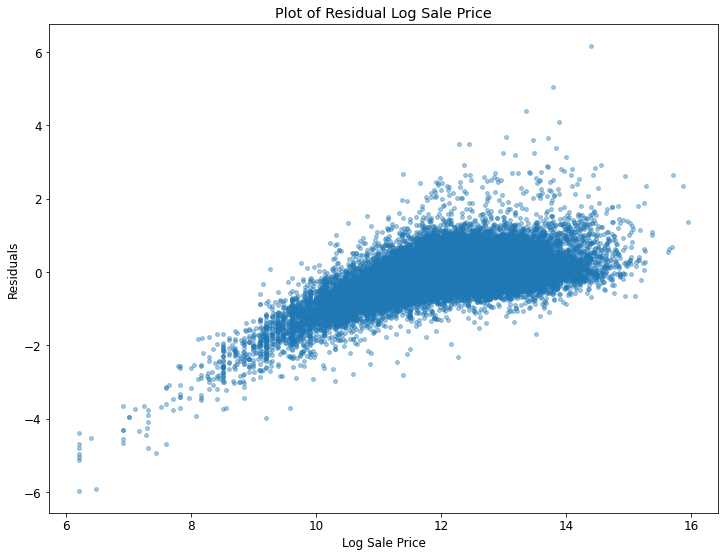

In [829]:
plt.scatter(y_test_m3, y_test_m3 - y_predicted_m3, s = 15, alpha = 0.4)
plt.xlabel("Log Sale Price")
plt.ylabel("Residuals")
plt.title("Plot of Residual Log Sale Price");

In addition, our residual plot looks much more centered around y = 0 than the residual plot from our simple model, which demonstrated a regressive tax structure. However, it seems that cheaper properties are still being over-predicted. This could be because there is less data on cheaper properties, so the model performs less accurately on them as a result.

In [830]:
theta0_m3 = linear_model_m3.intercept_
print("intercept:", theta0_m3)
linear_model_m3.coef_

intercept: -42.21549583181651


array([ 3.01914973e-01,  7.59132701e-01,  1.43872861e-01,  1.05434500e-01,
        1.17453721e-01, -8.29674279e-02, -7.99282507e-02, -3.08864887e-01,
        1.02850705e+00,  2.09909379e-05,  3.98622337e-02,  4.96480766e-02,
       -2.49962166e-02,  8.78368484e-02, -1.62821713e-04, -3.57141311e-02])

We can also see the intercept and feature coefficients. I was able to use this information to get rid of features that were less impactful on the model (features with smaller coefficients).